In [1]:
%matplotlib inline

from matplotlib import pyplot as plt

import numpy as np
import pycuda
import pycuda.compiler as cuda_compiler
import pycuda.driver as cuda_driver
from pycuda.gpuarray import GPUArray

from Timer import Timer
import IPythonMagic

import pytest
from ipytest import clean_tests, run_pytest

In [2]:
#These were from the IPythonMagic module
%setup_logging
%cuda_context_handler context

Python version 3.6.6 (default, Sep 12 2018, 18:26:19) 
[GCC 8.0.1 20180414 (experimental) [trunk revision 259383]]
Registering context in user workspace
Creating context
PyCUDA version 2018.1.1
CUDA version (9, 1, 0)
Driver version 10000
Using 'Tesla K80' GPU
 => compute capability: (3, 7)
 => memory: 10566 / 11441 MB available
Created context handle <58185056>
Using CUDA cache dir /home/ubuntu/jupyter_notebooks/Andre Brodtkorb/MilanoGPU2018/notebooks/cuda_cache


# Heat equation in 1D
The heat equation can be written
$$
\begin{align}
\frac{\partial u}{\partial t} &= \kappa \nabla^2 u\\
&= \kappa \frac{\partial^2 u}{\partial x^2}
\end{align}
$$
where $u$ is the temperature, and $\kappa$ is the material specific heat conduction constant. 

By approximating the temporal derivative with a backward difference, and the spatial derivative with a central difference, we get
$$
\frac{1}{\Delta t} (u_i^{n+1} - u_i^{n}) = \kappa \frac{1}{\Delta x^2}(u_{i-1}^n - 2u_i^n + u_{i+1}^n)
$$
and gathering $u^n+1$ on the left hand side and $u^n$on the right, we write
$$
u^{n+1}_i = u_i^n + \frac{\kappa\Delta t}{\Delta x^2}(u_{i-1}^n - 2u_i^n + u_{i+1}^n)
$$
This discretization is unstable if the following CFL condition is not met
$$
\frac{1}{2} \gt \frac{\kappa\Delta t}{\Delta x^2}
$$
or 
$$
\Delta t \lt \frac{\Delta x^2}{2\kappa}
$$

In [11]:
class HeatEquation1DGPU(object):
    """
    This class approximates the solution of the heat eqution
    using an explicit finite difference scheme on the GPU
    """
    
    def __init__(self):
        pass
    
    def createKernel(self):
        src = """
        __global__ void heatEquation(float* u1, const float* u0,
                            float kappa, float dx, float dt,
                            int nx) {
            // Skip the first ghost cell, i.e., plus one
            int i = blockIdx.x*blockDim.x + threadIdx.x + 1;
            
            //This handles internal cells 
            if (i >= 1 && i <= nx) {
                u1[i] = u0[i] + kappa*dt/(dx*dx) *
                            (u0[i-1] - 2.0f*u0[i] + u0[i+1]);
            }
            
            //This handles the left boundary
            if (i == 1) {
                u1[0] = u0[i] + kappa*dt/(dx*dx) *
                            (u0[i-1] - 2.0f*u0[i] + u0[i+1]);
            }
            
            //This handles the right boundary
            if (i == nx) {
                u1[nx+1] = u0[i] + kappa*dt/(dx*dx) *
                            (u0[i-1] - 2.0f*u0[i] + u0[i+1]);
            }
        }
        
        //This is a device function, which we can call from the kernel
        __device__ int computePi() {
            return 3.14156f;
        }
        """
        
        self.module = cuda_compiler.SourceModule(src, \
                                            options=['--use_fast_math'])
        self.kernel = self.module.get_function("heatEquation")
        # float* u1, const float* u0,
        # float kappa, float dx, float dt,
        # int nx
        self.kernel.prepare("PPfffi")
    
    def initialize(self, u0, kappa, dx, dt):
        self.kappa = np.float32(kappa)
        self.dx = np.float32(dx)
        self.dt = np.float32(dt)
        #Nx is u0.shape minus two because of boundaries
        self.nx = np.int32(u0.shape[0] - 2)
        
        #Allocate data on the GPU and upload
        assert u0.dtype == np.float32, "u0 must be float"
        self.u0_g = GPUArray(u0.shape, u0.dtype)
        self.u1_g = GPUArray(u0.shape, u0.dtype)
        self.u0_g.set(u0)
        
        #Create the kernel
        self.createKernel()
        
        num_threads = 128
        self.block_size = (num_threads, 1, 1)
        self.grid_size = (int(np.ceil(self.u0_g.shape[0] / num_threads)), 1, 1)
        self.stream = cuda_driver.Stream()
        print("Grid size is: ", self.grid_size)
        print("Block size is: ", self.block_size)
        print("U0 shape is: ", self.u0_g.shape)
        
    def step(self):
        #for i in range(1, self.nx+1):
        #    self.u1[i] = self.u0[i] \
        #         + self.kappa*self.dt/self.dx**2 \
        #         * (self.u0[i-1] - 2.0*self.u0[i] + self.u0[i+1])
        
        
        # float* u1, const float* u0,
        # float kappa, float dx, float dt,
        # int nx
        self.kernel.prepared_async_call(\
                self.grid_size, self.block_size, self.stream, \
                self.u1_g.gpudata, self.u0_g.gpudata, \
                self.kappa, self.dx, self.dt, \
                self.nx)
        
        # We will fix the BC in the kernel!
        #self.u1[0] = self.u1[1]
        #self.u1[self.nx+1] = self.u1[self.nx]
        
        #Swap u1 and u0
        #After step is complete, u0 is the most
        #recent result
        self.u0_g, self.u1_g = self.u1_g, self.u0_g
        
            
    def download(self):
        u0 = np.empty(self.u0_g.shape, self.u0_g.dtype)
        self.u0_g.get(u0)
        return u0

In [12]:
u0 = np.zeros(5, dtype=np.float32)
u0[2] = 1.0
kappa = 1.0
dx = 1.0
dt = 0.4*dx**2.0/(2.0*kappa)

gpu_simulator = HeatEquation1DGPU()
gpu_simulator.initialize(u0, kappa, dx, dt)

gpu_simulator.step()
result = gpu_simulator.download()
print(result)

#for i in range(10):
#    simulator.step()
#result = simulator.download()
#fig = plt.figure()
#plt.plot(result)

Grid size is:  (1, 1, 1)
Block size is:  (128, 1, 1)
U0 shape is:  (5,)
[0.2 0.2 0.6 0.2 0.2]


In [5]:
print(gpu_simulator.kernel)

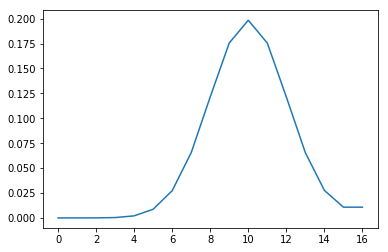

In [33]:
u0 = np.zeros(17)
u0[10] = 1.0
kappa = 1.0
dx = 1.0
dt = 0.4*dx**2.0/(2.0*kappa)

simulator = HeatEquation1D(u0, kappa, dx, dt)
for i in range(10):
    simulator.step()
result = simulator.download()
fig = plt.figure()
plt.plot(result)

In [31]:
clean_tests()

def test_HeatEquation1D():
    u0 = np.zeros(15)
    kappa = 1.0
    dx = 1.0
    dt = 0.4*dx**2.0/(2.0*kappa)

    simulator = HeatEquation1D(u0, kappa, dx, dt)

    assert np.all(u0 == simulator.u0)
    assert simulator.u0.shape == simulator.u1.shape
    assert kappa == simulator.kappa
    assert dx == simulator.dx
    assert dt == simulator.dt
    
    
    
    u0 = np.zeros(7)
    u0[3] = 1.0
    kappa = 1.0
    dx = 1.0
    dt = 0.4*dx**2.0/(2.0*kappa)

    simulator = HeatEquation1D(u0, kappa, dx, dt)
    for i in range(10):
        simulator.step()
        result = simulator.download()
        print(result)
        assert np.sum(result[1:-1]) == pytest.approx(1.0)
        assert result[0] == result[1]
        assert result[u0.shape[0]-1] ==  result[u0.shape[0]-2]

run_pytest(filename='HeatEquation1DTesting.ipynb', pytest_options=['-vvv'])

============================= test session starts ==============================
platform linux -- Python 3.6.6, pytest-3.8.2, py-1.6.0, pluggy-0.7.1 -- /usr/bin/python3
cachedir: .pytest_cache
rootdir: /home/ubuntu/jupyter_notebooks/Andre Brodtkorb/MilanoGPU2018/notebooks, inifile:
collecting ... collected 1 item

HeatEquation1DTesting.py::test_HeatEquation1D <- <ipython-input-31-db2fae1f6a54> PASSED [100%]

=========================== 1 passed in 0.03 seconds ===========================


0